In [203]:
# Importing the relevant libraries
import os
from dotenv import load_dotenv
import langchain
from langchain_openai import OpenAI, ChatOpenAI
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import display, Markdown, Image
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser,StrOutputParser
from langchain_community.callbacks import get_openai_callback
from langchain_core.globals import set_llm_cache
from langchain_core.caches import InMemoryCache
from langchain.memory import ConversationBufferMemory,ConversationBufferWindowMemory, VectorStoreRetrieverMemory
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda, RunnableParallel, RunnableBranch
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory, SQLChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from operator import itemgetter
import pandas as pd

In [3]:
# loading the environment variables
load_dotenv()

True

In [4]:
# Interfacing with chat models
chatgpt = ChatOpenAI(model = "gpt-4o-mini",temperature = 0)

In [6]:
prompt = "Explain the {topic} in 3 bullet points."
prompt_template = PromptTemplate.from_template(prompt)

In [7]:
chain = (
    prompt_template
          |
        chatgpt
)

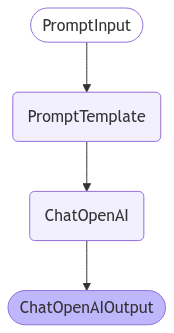

In [10]:
# Displaying chain using IPython
display(Image(chain.get_graph().draw_mermaid_png()))

In [11]:
# Displaying chain using grandalf
print(chain.get_graph().draw_ascii())

  +-------------+    
  | PromptInput |    
  +-------------+    
          *          
          *          
          *          
 +----------------+  
 | PromptTemplate |  
 +----------------+  
          *          
          *          
          *          
   +------------+    
   | ChatOpenAI |    
   +------------+    
          *          
          *          
          *          
+------------------+ 
| ChatOpenAIOutput | 
+------------------+ 


In [13]:
response = chain.invoke({"topic": "theory of relativity"})
display(Markdown(response.content))

- **Space-Time Continuum**: The theory of relativity, developed by Albert Einstein, combines space and time into a single four-dimensional continuum known as space-time. Events are described by their position in both space and time, emphasizing that the measurements of time and distance can vary depending on the observer's relative motion.

- **Relative Motion and Time Dilation**: One of the key implications of relativity is that time is not absolute; it can pass at different rates for observers in different states of motion. This phenomenon, known as time dilation, means that a clock moving at a significant fraction of the speed of light will tick more slowly compared to a stationary clock.

- **Mass-Energy Equivalence**: The famous equation \(E=mc^2\) illustrates the principle of mass-energy equivalence, indicating that mass can be converted into energy and vice versa. This relationship implies that a small amount of mass can be transformed into a large amount of energy, which is the underlying principle for nuclear reactions.

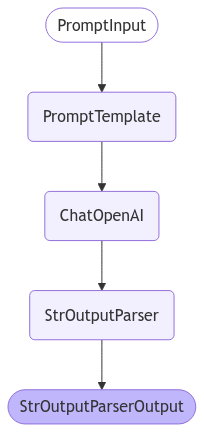

In [15]:
chain = (
    prompt_template
          |
       chatgpt
          |
    StrOutputParser()
)

display(Image(chain.get_graph().draw_mermaid_png()))


In [17]:
# response = chain.invoke({"topic": "theory of relativity"})
display(Markdown(response))

- **Space-Time Continuum**: The theory of relativity, developed by Albert Einstein, combines space and time into a single four-dimensional continuum known as space-time. Events are described by their position in both space and time, emphasizing that the measurements of time and distance can vary depending on the observer's relative motion.

- **Relative Motion and Time Dilation**: One of the key principles is that the laws of physics are the same for all observers, regardless of their relative motion. This leads to phenomena such as time dilation, where time passes at different rates for observers in different frames of reference, particularly at high speeds or in strong gravitational fields.

- **Mass-Energy Equivalence**: The famous equation \(E=mc^2\) illustrates the equivalence of mass and energy, indicating that mass can be converted into energy and vice versa. This principle has profound implications in physics, including the understanding of nuclear reactions and the energy produced by stars.

In [18]:
print(response)

- **Space-Time Continuum**: The theory of relativity, developed by Albert Einstein, combines space and time into a single four-dimensional continuum known as space-time. Events are described by their position in both space and time, emphasizing that the measurements of time and distance can vary depending on the observer's relative motion.

- **Relative Motion and Time Dilation**: One of the key principles is that the laws of physics are the same for all observers, regardless of their relative motion. This leads to phenomena such as time dilation, where time passes at different rates for observers in different frames of reference, particularly at high speeds or in strong gravitational fields.

- **Mass-Energy Equivalence**: The famous equation \(E=mc^2\) illustrates the equivalence of mass and energy, indicating that mass can be converted into energy and vice versa. This principle has profound implications in physics, including the understanding of nuclear reactions and the energy prod

In [19]:
reviews = [
    f"""
    Purchased this adorable koala plush toy for my nephew's birthday,
    and he's absolutely smitten with it, carrying it around everywhere he goes.
    The plush is incredibly soft, and the koala's face has an endearing expression.
    However, I did find it a tad on the smaller side given its price point.
    I believe there may be larger alternatives available at a similar price.
    To my delight, it arrived a day earlier than anticipated,
    allowing me to enjoy it briefly before gifting it to him.
    """,
    f"""
    Required a stylish lamp for my office space, and this particular one
    came with added storage at a reasonable price.
    The delivery was surprisingly quick, arriving within just two days.
    However, the pull string for the lamp suffered damage during transit.
    To my relief, the company promptly dispatched a replacement,
    which arrived within a few days. Assembly was a breeze.
    Then, I encountered an issue with a missing component,
    but their support team responded swiftly and provided the missing part.
    It appears to be a commendable company that genuinely values its
    customers and the quality of its products.
    """
    ]

In [20]:
prompt = """
            Act as a product review analyst.
            Your task is to generate a short summary of a product
            review from an ecommerce site.

            Generate a summary of the review (max 2 lines)
            Also show both the positives and negatives from the review (max 2 bullets)

            ```{review}```
"""
prompt_template = ChatPromptTemplate.from_template(prompt)


In [21]:
chain = (
    prompt_template
          |
       chatgpt
          |
    StrOutputParser()
)

In [23]:
formatted_input = [{"review": review} for review in reviews]
responses = chain.map().invoke(formatted_input)
for response in responses:
    display(Markdown(response))
    print("\n")

**Summary:** The koala plush toy is soft and charming, making it a hit with the recipient, though its size may not justify the price.

**Positives:**
- Incredibly soft and endearing design.
- Arrived earlier than expected.

**Negatives:**
- Smaller than anticipated for the price.
- Potentially larger alternatives available.

**Summary:** A stylish and functional lamp with quick delivery and excellent customer support, though it had some initial issues with damaged and missing components.

**Positives:**
- Quick delivery and easy assembly.
- Responsive customer support that promptly addressed issues.

**Negatives:**
- Pull string was damaged during transit.
- Missing component required additional support intervention.

In [5]:
prompt = "{query}"
prompt_template = ChatPromptTemplate.from_template(prompt)

chain = (
    prompt_template
          |
       chatgpt
          |
    StrOutputParser()
)

In [6]:
response = chain.invoke({"query": "What is the capital of France?"})
print(response)

The capital of France is Paris.


In [7]:
response = chain.invoke({"query": "Give me the same for India?"})
print(response)

Could you please clarify what specific information or topic you would like to know about India? This could include aspects like culture, history, geography, economy, politics, or any other area of interest.


We can see that llm fails to answer the second query passed by user due to its inability to store historical converstaions.

Understanding Important concepts like runnable lambda and runnable pasthrough

In [27]:
# to convert and python function to langchain function we need runnable lambda
RunnableLambda(lambda x: 100 if x["x"] > 10 else x)

RunnableLambda(lambda x: 100 if x['x'] > 10 else x)

In [28]:
# Runnable pass through send the output of any runnable lambda as it is to the chain
# but we want to modify the output of the Runnable lambda by sending it with both input (current query) and output (history)
runnable = RunnablePassthrough().assign(
    output = RunnableLambda((lambda x: 100 if x["x"] > 10 else x))
                                        )
runnable.invoke({"x": 50})

{'x': 50, 'output': 100}

# conversation buffer memory

In [111]:
SYS_PROMPT = """Act as a helpful assistant and give brief answers"""
message = [
    ("system",SYS_PROMPT),
    MessagesPlaceholder(variable_name="history"),
    ('human',"{query}")
]
template = ChatPromptTemplate.from_messages(messages=message)

memory = ConversationBufferMemory(return_messages = True)

In [113]:
memory.load_memory_variables({})['history']

[]

In [38]:
# Function to extract history from memory
def get_history(query):
    return memory.load_memory_variables(query)['history']

In [39]:
# Function to pass both history and query into the chain
chain = (
    RunnablePassthrough.assign(
    history = RunnableLambda(get_history))
                    |
                 template
                    |
                 chatgpt
                    |
              StrOutputParser()
        )


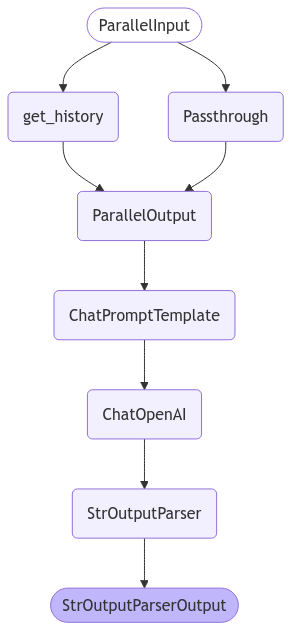

In [40]:
display(Image(chain.get_graph().draw_mermaid_png()))

In [47]:
query = {"query": "What is the capital of France?"}
response = chain.invoke(query)
print(response)
memory.save_context(query, {"output": response})

The capital of France is Paris.


In [48]:
memory.load_memory_variables({})['history']

[HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='The capital of France is Paris.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='The capital of France is Paris.', additional_kwargs={}, response_metadata={})]

In [49]:
query = {"query": "Do the same for India?"}
response = chain.invoke(query)
print(response)
memory.save_context(query, {"output": response})

The capital of India is New Delhi.


In [50]:
memory.load_memory_variables({})['history']

[HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='The capital of France is Paris.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='The capital of France is Paris.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Do the same for India?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='The capital of India is New Delhi.', additional_kwargs={}, response_metadata={})]

# conversation buffer window memory

In [52]:
SYS_PROMPT = """Act as a helpful assistant and give brief answers"""
messages = [
    ("system",SYS_PROMPT),
    MessagesPlaceholder(variable_name="history"),
    ('human',"{query}")
]

template = ChatPromptTemplate.from_messages(messages=messages)

memory = ConversationBufferWindowMemory(return_messages = True, k=2)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11836\3683873329.py:10: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferWindowMemory(return_messages = True, k=2)


In [108]:
def get_history(query):
    return memory.load_memory_variables(query)['history']

In [54]:
chain = (
    RunnablePassthrough.assign(
    history = RunnableLambda(get_history))
                    |
                 template
                    |
                 chatgpt
                    |
              StrOutputParser()
        )

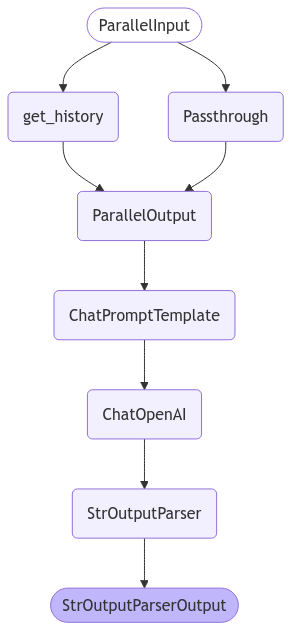

In [55]:
display(Image(chain.get_graph().draw_mermaid_png()))

In [58]:
query = {"query": "What is the capital of France?"}
response = chain.invoke(query)
print(response)
memory.save_context(query, {"output": response})

The capital of France is Paris.


In [59]:
query = {"query": "Do the same for India?"}
response = chain.invoke(query)
print(response)
memory.save_context(query, {"output": response})

The capital of India is New Delhi.


#### Create a Vector Database to store conversation history

Here we use the Chroma vector DB and initialize an empty database collection to store conversation messages

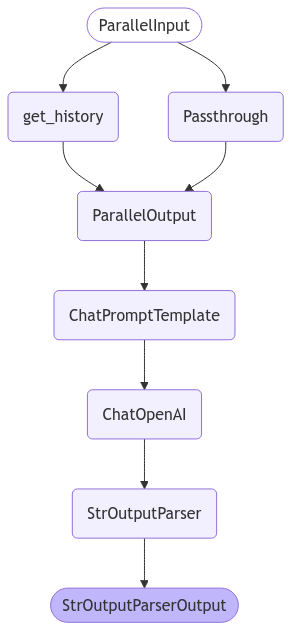

In [114]:
conversation_chain = (
    RunnablePassthrough.assign(
        history=RunnableLambda(get_memory_messages)
    ) # sends current query (input by user at runtime) and history messages to next step
      |
    prompt # creates prompt using the previous two variables
      |
    chatgpt # generates response using the prompt from previous step
)


#creating an embedding model
open_ai_embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
# create an empty vector db
chroma = Chroma(collection_name='history_db',
                 embedding_function=open_ai_embeddings)
SYS_PROMPT = """Act as a helpful assistant and give brief answers"""
message = [
    ("system",SYS_PROMPT),
    MessagesPlaceholder(variable_name="history"),
    ('human',"{query}"),
]
template = ChatPromptTemplate.from_messages(message)

retreiver = chroma.as_retriever(search_type="similarity",
                                   search_kwargs={"k": 2})
memory = VectorStoreRetrieverMemory(retriever=retreiver,return_messages = True)

def get_history(query):
    return [memory.load_memory_variables(query)['history']]
chain = (
    RunnablePassthrough.assign(
    history = RunnableLambda(get_history))
                    |
                 template
                    |
                 chatgpt
                    |
              StrOutputParser()
        )
display(Image(chain.get_graph().draw_mermaid_png()))

In [117]:
query = {'query': 'Tell me about AI'}
response = chain.invoke(query)
memory.save_context(query, {"output": response}) # remember to save your current conversation in memory
display(Markdown(response))

Artificial Intelligence (AI) is a field of computer science that aims to create machines capable of performing tasks that typically require human intelligence. This includes abilities like learning, reasoning, problem-solving, and understanding language. Key components of AI include machine learning, deep learning, and natural language processing. AI is used in various applications, such as virtual assistants, autonomous vehicles, and healthcare diagnostics, and it raises important ethical and societal considerations.

In [122]:
query = {'query': 'What about deep learning'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response}) # remember to save your current conversation in memory
display(Markdown(response.content))

Deep learning is a branch of machine learning that uses neural networks with many layers to process and learn from large datasets. It is particularly effective for tasks like image and speech recognition, natural language processing, and more. Deep learning models can automatically identify features in data, making them powerful for complex problems, but they require substantial computational resources and large amounts of training data.

In [123]:
query = {'query': 'What about the cheetah?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response}) # remember to save your current conversation in memory
display(Markdown(response.content))

The cheetah is a large feline known for being the fastest land animal, capable of reaching speeds up to 60-70 mph (97-113 km/h) in short bursts covering distances up to 1,500 feet (460 meters). They have a lightweight body, long legs, and a unique respiratory system that allows for rapid acceleration. Cheetahs primarily hunt during the day and rely on their keen eyesight to spot prey, which mainly includes small to medium-sized ungulates. They are found in various habitats across Africa and parts of Iran, but their populations are declining due to habitat loss and human-wildlife conflict.

In [124]:
print(memory.load_memory_variables({'query': 'What about machine learning?'})['history'])

query: What about deep learning
output: content='Deep learning is a subset of machine learning that utilizes neural networks with multiple layers to analyze and learn from large datasets. It is particularly effective for tasks such as image and speech recognition, natural language processing, and more. Deep learning models automatically extract features from data, making them suitable for complex problems, but they require significant computational resources and large amounts of training data.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 661, 'total_tokens': 734, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None} id='run-d635dd39-64fd-43f8-b73a-a

In [137]:
history_store = {}
def get_session_history(session_id):
    if session_id not in history_store:
        history_store[session_id] = ChatMessageHistory()
    return history_store[session_id]

prompt = ChatPromptTemplate.from_messages([
    ("system", "Act as a helpful assistant and give brief answers"),
    MessagesPlaceholder(variable_name="history"),
    ("human", "{query}")
])

chain = (
    prompt
      |
    chatgpt
      |
StrOutputParser()
)

conv_chain = RunnableWithMessageHistory(
    get_session_history=get_session_history,
    runnable=chain,
    input_messages_key="query",
    history_messages_key="history",
)
def chat_llm(prompt:str,session_id:str):
    for chunk in conv_chain.stream({"query": prompt},
                                   {"configurable": {"session_id": session_id}}):
        print(chunk,end='',flush=True)

In [138]:
user_id = 'bob123'
prompt = "Hi I am Bob, can you explain AI in 3 bullet points?"
chat_llm(prompt, user_id)

Sure, Bob! Here are three key points about AI:

1. **Definition**: Artificial Intelligence (AI) refers to the simulation of human intelligence in machines programmed to think and learn like humans, enabling them to perform tasks such as problem-solving, understanding language, and recognizing patterns.

2. **Types**: AI can be categorized into two main types: Narrow AI, which is designed for specific tasks (like virtual assistants), and General AI, which aims to understand and reason across a wide range of tasks, similar to human intelligence.

3. **Applications**: AI is used in various fields, including healthcare (diagnosing diseases), finance (fraud detection), transportation (self-driving cars), and customer service (chatbots), enhancing efficiency and decision-making.

In [140]:
prompt = "Now do the same for deep learning"
chat_llm(prompt, user_id)

Of course! Here are three key points about deep learning:

1. **Definition**: Deep learning is a subset of machine learning that uses neural networks with many layers (deep neural networks) to model complex patterns in large datasets, mimicking the way the human brain processes information.

2. **Architecture**: Deep learning models consist of interconnected layers of nodes (neurons) that transform input data through multiple levels of abstraction, allowing them to learn features automatically without manual feature extraction.

3. **Applications**: Deep learning is widely used in areas such as image and speech recognition, natural language processing, and autonomous systems, achieving state-of-the-art performance in tasks like facial recognition and language translation.

In [141]:
prompt = "Discuss briefly what have we discussed so far is bullet points?"
chat_llm(prompt, user_id)

Sure! Here’s a summary of what we’ve discussed so far in bullet points:

- **Artificial Intelligence (AI)**:
  - Simulates human intelligence in machines for tasks like problem-solving and language understanding.
  - Categorized into Narrow AI (specific tasks) and General AI (broad reasoning).
  - Applications include healthcare, finance, transportation, and customer service.

- **Deep Learning**:
  - A subset of machine learning using deep neural networks to model complex patterns.
  - Comprises multiple layers of interconnected nodes for automatic feature learning.
  - Used in image and speech recognition, natural language processing, and autonomous systems.

In [142]:
user_id = 'james007'
prompt = "Hi can you explain what is an LLM in 2 bullet points?"
chat_llm(prompt, user_id)

- **Definition**: A Large Language Model (LLM) is an advanced artificial intelligence system designed to understand and generate human-like text based on vast amounts of data.
- **Applications**: LLMs are used in various applications, including chatbots, content creation, translation, and summarization, enhancing communication and information processing.

In [143]:
prompt = "can you explain what is an LLM in 2 bullet points in context of law?"
chat_llm(prompt, user_id)

- **Definition**: In the context of law, an LLM (Master of Laws) is a postgraduate academic degree for legal professionals seeking to deepen their knowledge in specific areas of law or gain expertise in international legal practices.
- **Purpose**: The LLM program often enhances career prospects, allows for specialization in fields such as tax law, human rights, or intellectual property, and may be a requirement for certain legal positions or academic roles.

In [144]:
prompt = "can you summarize what we have learnt so far?"
chat_llm(prompt, user_id)

- **Large Language Model (LLM)**: An advanced AI system that understands and generates human-like text, used in various applications like chatbots and content creation.
- **LLM in Law**: A postgraduate degree (Master of Laws) for legal professionals to specialize in specific legal areas, enhancing career prospects and expertise.

### Multi-user Window-based Conversation Chains with persistence - SQLChatMessageHistory

In [145]:
# removes the memory database file - usually not needed
# you can run this only when you want to remove all conversation histories
!rm memory.db

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [152]:
# used to retrieve conversation history from database
# based on a specific user or session ID
def get_session_history_db(session_id):
    return SQLChatMessageHistory(session_id, "sqlite:///memory.db")

# prompt to load in history and current input from the user
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "Act as a helpful AI Assistant"),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{human_input}"),
    ]
)

# create a memory buffer window function to return the last K conversations
def memory_buffer_window(messages, k=2):
    return messages[-(k+1):]

# create a basic LLM Chain which only sends the last K conversations per user
llm_chain = (
    RunnablePassthrough.assign(history=lambda x: memory_buffer_window(x["history"]))
      |
    prompt_template
      |
    chatgpt
)

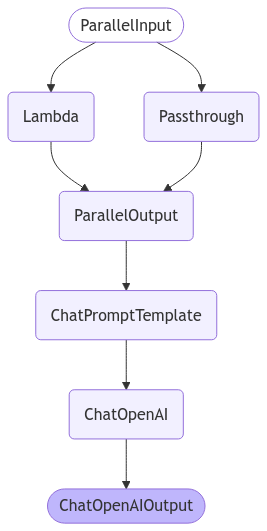

In [153]:
display(Image(llm_chain.get_graph().draw_mermaid_png()))

In [154]:
conv_chain = RunnableWithMessageHistory(
    llm_chain,
    get_session_history_db,
    input_messages_key="human_input",
    history_messages_key="history",
)

# create a utility function to take in current user input prompt and their session ID
# streams result live back to the user from the LLM
def chat_with_llm(prompt: str, session_id: str):
    for chunk in conv_chain.stream({"human_input": prompt},
                                   {'configurable': { 'session_id': session_id}}):
        print(chunk.content, end="")

In [155]:
user_id = 'jim001'
prompt = "Hi can you tell me which is the fastest animal?"
chat_with_llm(prompt, user_id)

c:\Users\LENOVO\Documents\GitHub\Generative-AI\.venv\Lib\site-packages\langchain_core\runnables\history.py:608: LangChainDeprecationWarning: `connection_string` was deprecated in LangChain 0.2.2 and will be removed in 1.0. Use connection instead.
  message_history = self.get_session_history(


The fastest animal in the world is the peregrine falcon. When in a dive, it can reach speeds of over 240 miles per hour (386 kilometers per hour). If you're considering speed in level flight, the Brazilian free-tailed bat holds the record, flying at speeds of around 99 miles per hour (160 kilometers per hour). For land animals, the cheetah is the fastest, capable of running speeds up to 60-70 miles per hour (97-113 kilometers per hour) in short bursts.

In [156]:
prompt = "what about the slowest animal?"
chat_with_llm(prompt, user_id)

The slowest animal is often considered to be the three-toed sloth. It moves at an average speed of about 0.24 kilometers per hour (0.15 miles per hour) when climbing trees. In water, they can swim slightly faster, but they are still quite slow compared to many other animals. Another contender for the title of slowest animal is the garden snail, which moves at a speed of about 0.03 miles per hour (0.048 kilometers per hour). Both of these animals have adapted to their slow pace as part of their survival strategies.

In [157]:
prompt = "what about the largest animal?"
chat_with_llm(prompt, user_id)

The largest animal on Earth is the blue whale (*Balaenoptera musculus*). Blue whales can reach lengths of up to 100 feet (30 meters) or more and can weigh as much as 200 tons (approximately 181 metric tonnes). These magnificent marine mammals are not only the largest animals alive today but are also believed to be the largest animals to have ever existed on Earth, surpassing even the largest dinosaurs. Their immense size is supported by their diet, which primarily consists of tiny shrimp-like animals called krill.

In [158]:
prompt = "what topics have we discussed, show briefly as bullet points"
chat_with_llm(prompt, user_id)

Sure! Here are the topics we've discussed so far:

- The slowest animal (three-toed sloth and garden snail)
- The largest animal (blue whale)

In [159]:
user_id = 'john005'
prompt = "Explain AI in 3 bullets to a child"
chat_with_llm(prompt, user_id)

Sure! Here are three simple points to explain AI to a child:

1. **Smart Helpers**: AI is like a smart robot or computer that can help us with tasks, like answering questions or playing games, just like a friend would.

2. **Learning from Experience**: AI learns from lots of information, kind of like how you learn from your school lessons or by practicing something over and over.

3. **Making Decisions**: AI can make choices based on what it has learned, like picking the best answer to a question or suggesting a fun movie to watch!

In [160]:
prompt = "Now do the same for Generative AI"
chat_with_llm(prompt, user_id)

Of course! Here are three simple points to explain Generative AI to a child:

1. **Creative Robot**: Generative AI is like a creative robot that can make new things, like stories, pictures, or music, just like an artist or a writer.

2. **Using Examples**: It learns by looking at lots of examples, like reading many books or seeing many drawings, so it can create something new that’s similar but different.

3. **Imagination Power**: Generative AI uses its imagination to come up with fun ideas or cool designs, helping us create things we might not think of on our own!

In [161]:
prompt = "Now do the same for machine learning"
chat_with_llm(prompt, user_id)

Sure! Here are three simple points to explain machine learning to a child:

1. **Learning Like You**: Machine learning is when computers learn from experience, just like you learn new things by practicing and trying different activities.

2. **Finding Patterns**: It helps computers notice patterns in information, like how you might recognize your favorite animals by their colors or shapes.

3. **Getting Better Over Time**: The more data or examples the computer sees, the better it gets at making predictions or decisions, just like how you get better at a game the more you play it!

In [162]:
prompt = "what topics have we discussed, show briefly as bullet points"
chat_with_llm(prompt, user_id)

Sure! Here are the topics we've discussed so far:

- **Generative AI**
  - Creative robot that makes new things (stories, pictures, music)
  - Learns from examples to create something new
  - Uses imagination to come up with fun ideas

- **Machine Learning**
  - Computers learn from experience like humans
  - Recognizes patterns in information
  - Improves over time with more data and practice

## Linking Multiple Chains Sequentially in LCEL

In [163]:
it_support_queue = [
    "I can't access my email. It keeps showing an error message. Please help.",
    "Tengo problemas con la VPN. No puedo conectarme a la red de la empresa. ¿Pueden ayudarme, por favor?",
    "Mon imprimante ne répond pas et n'imprime plus. J'ai besoin d'aide pour la réparer.",
    "我无法访问公司的网站。每次都显示错误信息。请帮忙解决。"
]

it_support_queue

["I can't access my email. It keeps showing an error message. Please help.",
 'Tengo problemas con la VPN. No puedo conectarme a la red de la empresa. ¿Pueden ayudarme, por favor?',
 "Mon imprimante ne répond pas et n'imprime plus. J'ai besoin d'aide pour la réparer.",
 '我无法访问公司的网站。每次都显示错误信息。请帮忙解决。']

In [164]:
# Chain 1: Detect customer message language
prompt1 = """
  Act as a customer support agent.
  For the customer support message delimited below by triple backticks,
  Output the language of the message in one word only, e.g. Spanish

  Customer Message:
  ```{orig_msg}```
"""
prompt_template1 = ChatPromptTemplate.from_template(prompt1)
llm_chain1 = (prompt_template1
                  |
              chatgpt
                  |
              StrOutputParser())

In [165]:
# Chain 2: Translate Customer Message to English
prompt2 = """
  Act as a customer support agent.
  For the customer message and customer message language delimited below by triple backticks,
  Translate the customer message from the customer message language to English
  if customer message language is not in English,
  else return back the original customer message.

  Customer Message:
  ```{orig_msg}```
  Customer Message Language:
  ```{orig_lang}```
"""
prompt_template2 = ChatPromptTemplate.from_template(prompt2)
llm_chain2 = (prompt_template2
                  |
              chatgpt
                  |
              StrOutputParser())

In [166]:
# Chain 3: Generate a resolution response in English
prompt3 = """
  Act as a customer support agent.
  For the customer support message delimited below by triple backticks,
  Generate an appropriate resolution response in English.

  Customer Message:
  ```{trans_msg}```
"""
prompt_template3 = ChatPromptTemplate.from_template(prompt3)
llm_chain3 = (prompt_template3
                  |
              chatgpt
                  |
              StrOutputParser())

In [167]:
# Chain 4: Translate resolution response from English to Customer's original language
prompt4 = """
  Act as a customer support agent.
  For the customer resolution response and target language delimited below by triple backticks,
  Translate the customer resolution response message from English to the target language
  if target language is not in English,
  else return back the original customer resolution response.

  Customer Resolution Response:
  ```{trans_response}```
  Target Language:
  ```{orig_lang}```
"""
prompt_template4 = ChatPromptTemplate.from_template(prompt4)
llm_chain4 = (prompt_template4
                  |
              chatgpt
                  |
              StrOutputParser())

In [169]:
chain = (
    RunnablePassthrough.assign(orig_lang = llm_chain1)
                               |
    RunnablePassthrough.assign(trans_msg = llm_chain2)
                               |
    RunnablePassthrough.assign(trans_response = llm_chain3)
                               |
    RunnablePassthrough.assign(orig_response = llm_chain4)
)

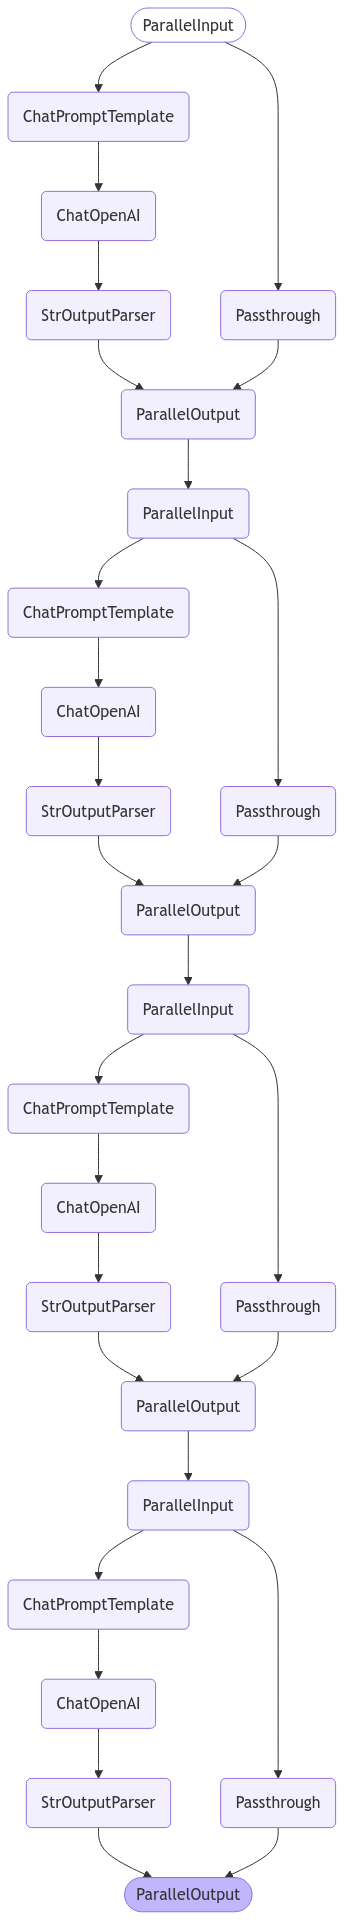

In [170]:
display(Image(chain.get_graph().draw_mermaid_png()))

In [172]:
response = chain.invoke({'orig_msg': it_support_queue[1]})
response

{'orig_msg': 'Tengo problemas con la VPN. No puedo conectarme a la red de la empresa. ¿Pueden ayudarme, por favor?',
 'orig_lang': 'Spanish',
 'trans_msg': "I am having problems with the VPN. I can't connect to the company's network. Can you please help me?",
 'trans_response': "Subject: Assistance with VPN Connection Issues\n\nDear [Customer's Name],\n\nThank you for reaching out to us regarding the issues you are experiencing with the VPN. I understand how important it is to connect to the company's network, and I'm here to help you resolve this matter.\n\nHere are a few troubleshooting steps you can try:\n\n1. **Check Your Internet Connection**: Ensure that you have a stable internet connection. You can try accessing a website to confirm.\n\n2. **Restart the VPN Application**: Close the VPN application completely and then reopen it. Sometimes, a simple restart can resolve connection issues.\n\n3. **Verify Your Credentials**: Double-check that you are entering the correct username an

In [173]:
formatted_input = [{"orig_msg": msg} for msg in it_support_queue]

In [177]:
responses = chain.map().invoke(formatted_input)
count=0
for response in responses:
    for k,v in response.items():
        display(Markdown(f"{k}: {v}"))
    print("*"*50)

orig_msg: I can't access my email. It keeps showing an error message. Please help.

orig_lang: English

trans_msg: I can't access my email. It keeps showing an error message. Please help.

trans_response: Subject: Assistance with Email Access

Dear [Customer's Name],

Thank you for reaching out to us. I’m sorry to hear that you’re having trouble accessing your email. I’d be happy to help you resolve this issue.

To assist you better, could you please provide me with the following information:
1. The exact error message you are seeing.
2. The device and browser (or app) you are using to access your email.
3. Any troubleshooting steps you have already tried (e.g., resetting your password, clearing your browser cache).

In the meantime, here are a few general troubleshooting steps you can try:
- Ensure that you are connected to the internet.
- Try accessing your email from a different browser or device.
- Clear your browser's cache and cookies, then restart the browser.
- If you are using an email app, try uninstalling and reinstalling it.

Once I have the additional information, I’ll be able to provide more specific guidance. Thank you for your patience, and I look forward to helping you resolve this issue.

Best regards,

[Your Name]  
Customer Support Team  
[Your Company]  
[Contact Information]

orig_response: Subject: Assistance with Email Access

Dear [Customer's Name],

Thank you for reaching out to us. I’m sorry to hear that you’re having trouble accessing your email. I’d be happy to help you resolve this issue.

To assist you better, could you please provide me with the following information:
1. The exact error message you are seeing.
2. The device and browser (or app) you are using to access your email.
3. Any troubleshooting steps you have already tried (e.g., resetting your password, clearing your browser cache).

In the meantime, here are a few general troubleshooting steps you can try:
- Ensure that you are connected to the internet.
- Try accessing your email from a different browser or device.
- Clear your browser's cache and cookies, then restart the browser.
- If you are using an email app, try uninstalling and reinstalling it.

Once I have the additional information, I’ll be able to provide more specific guidance. Thank you for your patience, and I look forward to helping you resolve this issue.

Best regards,

[Your Name]  
Customer Support Team  
[Your Company]  
[Contact Information]

**************************************************


orig_msg: Tengo problemas con la VPN. No puedo conectarme a la red de la empresa. ¿Pueden ayudarme, por favor?

orig_lang: Spanish

trans_msg: I am having problems with the VPN. I cannot connect to the company network. Can you please help me?

trans_response: Subject: Assistance with VPN Connection Issues

Dear [Customer's Name],

Thank you for reaching out to us regarding your VPN connection issues. I understand how important it is to access the company network, and I'm here to help you resolve this matter.

Here are a few troubleshooting steps you can try:

1. **Check Your Internet Connection**: Ensure that you have a stable internet connection. You can try accessing a website to confirm.

2. **Restart the VPN Application**: Close the VPN application completely and then reopen it. Sometimes, a simple restart can resolve connection issues.

3. **Reboot Your Device**: Restart your computer or device to refresh the network settings.

4. **Update the VPN Software**: Make sure that you are using the latest version of the VPN software. If not, please update it and try connecting again.

5. **Check VPN Credentials**: Double-check that you are entering the correct username and password. If you’re unsure, please verify your credentials with your IT department.

6. **Firewall/Antivirus Settings**: Sometimes, firewall or antivirus software can block VPN connections. Temporarily disable them to see if that resolves the issue.

If you have tried these steps and are still unable to connect, please provide me with any error messages you are receiving, and I will assist you further.

Thank you for your patience, and I look forward to helping you get connected!

Best regards,

[Your Name]  
Customer Support Team  
[Your Company]  
[Contact Information]

orig_response: ```Subject: Asistencia con problemas de conexión VPN

Estimado/a [Nombre del Cliente],

Gracias por contactarnos respecto a sus problemas de conexión VPN. Entiendo lo importante que es acceder a la red de la empresa, y estoy aquí para ayudarle a resolver este asunto.

Aquí hay algunos pasos de solución de problemas que puede intentar:

1. **Verifique su conexión a Internet**: Asegúrese de tener una conexión a Internet estable. Puede intentar acceder a un sitio web para confirmarlo.

2. **Reinicie la aplicación VPN**: Cierre completamente la aplicación VPN y luego vuelva a abrirla. A veces, un simple reinicio puede resolver problemas de conexión.

3. **Reinicie su dispositivo**: Reinicie su computadora o dispositivo para refrescar la configuración de red.

4. **Actualice el software VPN**: Asegúrese de estar utilizando la versión más reciente del software VPN. Si no es así, actualícelo e intente conectarse nuevamente.

5. **Verifique las credenciales VPN**: Verifique que esté ingresando el nombre de usuario y la contraseña correctos. Si no está seguro, verifique sus credenciales con su departamento de TI.

6. **Configuraciones de Firewall/Antivirus**: A veces, el software de firewall o antivirus puede bloquear las conexiones VPN. Desactívelos temporalmente para ver si eso resuelve el problema.

Si ha intentado estos pasos y aún no puede conectarse, por favor proporcióneme cualquier mensaje de error que esté recibiendo, y le ayudaré más.

Gracias por su paciencia, y espero poder ayudarle a conectarse.

Atentamente,

[Su Nombre]  
Equipo de Soporte al Cliente  
[Su Empresa]  
[Información de Contacto]```

**************************************************


orig_msg: Mon imprimante ne répond pas et n'imprime plus. J'ai besoin d'aide pour la réparer.

orig_lang: French

trans_msg: My printer is not responding and is no longer printing. I need help to fix it.

trans_response: Dear Customer,

Thank you for reaching out to us regarding your printer issue. I understand how frustrating it can be when your printer is not responding. Let’s work together to resolve this.

Here are some steps you can try to troubleshoot the problem:

1. **Check Connections**: Ensure that the printer is properly connected to your computer or network. If it’s a wired printer, check the USB or Ethernet cable. For wireless printers, make sure it is connected to the correct Wi-Fi network.

2. **Restart the Printer**: Turn off the printer, unplug it from the power source, wait for about 30 seconds, and then plug it back in and turn it on.

3. **Check for Error Messages**: Look at the printer’s display panel for any error messages or blinking lights that might indicate a specific issue.

4. **Update Drivers**: Make sure that your printer drivers are up to date. You can visit the manufacturer’s website to download the latest drivers.

5. **Set as Default Printer**: On your computer, go to the printer settings and ensure that your printer is set as the default printer.

6. **Run the Printer Troubleshooter**: If you are using Windows, you can run the built-in printer troubleshooter. Go to Settings > Devices > Printers & Scanners, select your printer, and click on "Manage" to find the troubleshooter option.

If you have tried these steps and the printer is still not responding, please let me know the make and model of your printer, as well as any error messages you may be seeing. I’ll be happy to assist you further.

Thank you for your patience, and I look forward to helping you get your printer back up and running!

Best regards,  
[Your Name]  
Customer Support Team

orig_response: ```French
Cher client,

Merci de nous avoir contactés au sujet de votre problème d'imprimante. Je comprends à quel point il peut être frustrant que votre imprimante ne réponde pas. Travaillons ensemble pour résoudre cela.

Voici quelques étapes que vous pouvez essayer pour dépanner le problème :

1. **Vérifiez les connexions** : Assurez-vous que l'imprimante est correctement connectée à votre ordinateur ou réseau. Si c'est une imprimante filaire, vérifiez le câble USB ou Ethernet. Pour les imprimantes sans fil, assurez-vous qu'elle est connectée au bon réseau Wi-Fi.

2. **Redémarrez l'imprimante** : Éteignez l'imprimante, débranchez-la de la source d'alimentation, attendez environ 30 secondes, puis rebranchez-la et rallumez-la.

3. **Vérifiez les messages d'erreur** : Regardez sur le panneau d'affichage de l'imprimante s'il y a des messages d'erreur ou des lumières clignotantes qui pourraient indiquer un problème spécifique.

4. **Mettez à jour les pilotes** : Assurez-vous que les pilotes de votre imprimante sont à jour. Vous pouvez visiter le site Web du fabricant pour télécharger les derniers pilotes.

5. **Définissez comme imprimante par défaut** : Sur votre ordinateur, allez dans les paramètres de l'imprimante et assurez-vous que votre imprimante est définie comme imprimante par défaut.

6. **Exécutez l'outil de dépannage de l'imprimante** : Si vous utilisez Windows, vous pouvez exécuter l'outil de dépannage intégré de l'imprimante. Allez dans Paramètres > Appareils > Imprimantes et scanners, sélectionnez votre imprimante et cliquez sur "Gérer" pour trouver l'option de dépannage.

Si vous avez essayé ces étapes et que l'imprimante ne répond toujours pas, veuillez me faire savoir la marque et le modèle de votre imprimante, ainsi que tout message d'erreur que vous pourriez voir. Je serai heureux de vous aider davantage.

Merci de votre patience, et j'ai hâte de vous aider à remettre votre imprimante en marche !

Cordialement,  
[Votre nom]  
Équipe de support client
```

**************************************************


orig_msg: 我无法访问公司的网站。每次都显示错误信息。请帮忙解决。

orig_lang: Chinese

trans_msg: I cannot access the company's website. It always shows an error message. Please help me resolve this.

trans_response: Dear Customer,

Thank you for reaching out to us. I’m sorry to hear that you’re having trouble accessing our website. Here are a few steps you can try to resolve the issue:

1. **Clear Your Browser Cache**: Sometimes, old cache files can cause loading issues. Try clearing your browser's cache and cookies, then restart your browser.

2. **Try a Different Browser**: If clearing the cache doesn’t work, please try accessing the website using a different web browser to see if the issue persists.

3. **Check Your Internet Connection**: Ensure that your internet connection is stable. You can try accessing other websites to confirm.

4. **Disable Browser Extensions**: Some browser extensions can interfere with website loading. Try disabling them temporarily to see if that resolves the issue.

5. **Check for Firewall or Antivirus Settings**: Occasionally, firewall or antivirus software can block access to certain websites. Please check your settings to ensure our website is not being blocked.

If you’ve tried all these steps and are still experiencing issues, please let us know the specific error message you are seeing, and we will assist you further.

Thank you for your patience, and we look forward to resolving this for you.

Best regards,  
[Your Name]  
Customer Support Team

orig_response: ```Chinese
亲爱的客户，

感谢您与我们联系。很抱歉听到您在访问我们的网站时遇到问题。以下是您可以尝试解决此问题的几个步骤：

1. **清除浏览器缓存**：有时，旧的缓存文件会导致加载问题。请尝试清除浏览器的缓存和 cookies，然后重新启动浏览器。

2. **尝试不同的浏览器**：如果清除缓存无效，请尝试使用不同的网页浏览器访问网站，以查看问题是否仍然存在。

3. **检查您的互联网连接**：确保您的互联网连接稳定。您可以尝试访问其他网站以确认。

4. **禁用浏览器扩展**：某些浏览器扩展可能会干扰网站加载。请尝试暂时禁用它们，以查看是否能解决问题。

5. **检查防火墙或杀毒软件设置**：有时，防火墙或杀毒软件可能会阻止访问某些网站。请检查您的设置，以确保我们的网站没有被阻止。

如果您尝试了所有这些步骤仍然遇到问题，请告诉我们您看到的具体错误信息，我们将进一步协助您。

感谢您的耐心，我们期待为您解决此问题。

此致，  
[您的名字]  
客户支持团队
```

**************************************************


# Branching and Merging

In [181]:
description_prompt = "Explain the {topic} in brief."
desc_template = ChatPromptTemplate.from_template(description_prompt)
pros_prompt = "Give me 2 bullet points describing the pros of the {topic}."
pros_template = ChatPromptTemplate.from_template(pros_prompt)
cons_prompt = "Give me 2 bullet points describing the cons of the {topic}"
cons_template = ChatPromptTemplate.from_template(cons_prompt)


desc_chain = (desc_template
              |
              chatgpt
              |
              StrOutputParser())

pros_chain = (pros_template
              |
              chatgpt
              |
              StrOutputParser())

cons_chain = (cons_template
              |
              chatgpt
              |
              StrOutputParser())

branch_chain = RunnableParallel(
    topic = itemgetter("topic"),
    description = desc_chain,
    pros  = pros_chain,
    cons = cons_chain
)

In [183]:
# Pydantic O/P Parser
class ChatResponse(BaseModel):
    description: str = Field(description="A brief description of the topic asked in the query.")
    pros: str = Field(pros="2 bullet points on the topic asked in the query.")
    cons: str = Field(cons="2 bullet points on the topic asked in the query.")

# Creating an instance of the PydanticOutputParser
output_parser = PydanticOutputParser(pydantic_object = ChatResponse)



PydanticOutputParser(pydantic_object=<class '__main__.ChatResponse'>)

In [186]:
final_prompt = """Create a report about {topic} with the following information:
                        Description:
                        {description}
                        Pros:
                        {pros}
                        Cons:
                        {cons}
      
      Follow the formatting instructions as per the prescribed way as shown below
      {formatting_principles}
      """
final_template = PromptTemplate(template=final_prompt,
    input_variables=["description","pros","cons"],
    partial_variables={"formatting_principles":output_parser.get_format_instructions()})

merge_chain = (final_template
               |
               chatgpt
               |
               output_parser)

final_chain = (branch_chain
               |
               merge_chain)

response = final_chain.invoke({"topic": "Generative AI"})

In [195]:
# Assuming response.dict() gives a dictionary like this:
response_data = response.dict()

# Create a Markdown formatted string from the dictionary
markdown_content = f"""
**Description**: {response_data.get('description', 'N/A')}

**Pros**:
{response_data.get('pros', 'N/A')}

**Cons**:
{response_data.get('cons', 'N/A')}
"""

# Display the formatted Markdown content
display(Markdown(markdown_content))

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11836\1531430820.py:2: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response_data = response.dict()



**Description**: Generative AI refers to a class of artificial intelligence models that are designed to create new content, such as text, images, music, or other data, based on the patterns and structures learned from existing data. Unlike traditional AI, which typically focuses on classification or prediction tasks, generative AI aims to generate novel outputs that resemble the training data.

**Pros**:
- Enhanced Creativity and Innovation: Generative AI can assist in brainstorming and generating new ideas, designs, and content, enabling creators and businesses to explore a wider range of possibilities and accelerate the innovation process.
- Efficiency and Automation: By automating repetitive tasks such as content creation, data analysis, and design generation, generative AI can significantly reduce time and resource expenditure, allowing professionals to focus on higher-level strategic activities.

**Cons**:
- Misinformation and Disinformation: Generative AI can produce highly convincing but false information, leading to the spread of misinformation and disinformation, which can have serious societal implications, including undermining trust in media and institutions.
- Ethical Concerns and Bias: Generative AI systems can inadvertently perpetuate and amplify existing biases present in their training data, leading to outputs that may reinforce stereotypes or discriminatory practices, raising ethical concerns about fairness and accountability.


In [202]:
df = pd.DataFrame({
    'Description': [response_data.get('description', 'N/A')],
    'Pros': [response_data.get('pros', 'N/A')],
    'Cons': [response_data.get('cons', 'N/A')]
})
df

,Description,Pros,Cons
0,Generative AI refers to a class of artificial ...,- Enhanced Creativity and Innovation: Generati...,- Misinformation and Disinformation: Generativ...


# Routing

In [204]:
classifier_prompt = """"
Given the user instructions below for analyzing customer review,
           classify it as only one of the following categories:
            - summarize
            - sentiment
            - email

          Do not respond with more than one word.

          Instructions:
          {instruction}
          """
class_template = ChatPromptTemplate.from_template(classifier_prompt)
classifier_chain = (class_template|chatgpt|StrOutputParser())


In [205]:
summary_prompt = ChatPromptTemplate.from_template(
    """Act as a customer review analyst, given the following customer review,
       generate a short summary (max 2 lines) of the review.

       Customer Review:
       {review}
""")

summary_chain = (
    summary_prompt
        |
    chatgpt
        |
    StrOutputParser()
)

In [206]:
sentiment_prompt = ChatPromptTemplate.from_template(
    """Act as a customer review analyst, given the following customer review,
       find out the sentiment of the review.
       The sentiment can be either positive, negative or neutral.
       Return the result as a single word.

       Customer Review:
       {review}
""")

sentiment_chain = (
    sentiment_prompt
        |
    chatgpt
        |
    StrOutputParser()
)

In [207]:
email_prompt = ChatPromptTemplate.from_template(
    """Act as a customer review analyst,
    given the following customer review and its sentiment
    generate an email response to the customer based on the following conditions.
     - If the sentiment is positive or neutral thank them for their review
     - If the sentiment is negative, apologize to them

    Customer Review:
    {review}
    Sentiment:
    {sentiment}
""")

email_chain = (
    email_prompt
        |
    chatgpt
        |
    StrOutputParser()
)

In [208]:
def default_answer(query):
  return "Sorry instructions are not the defined intents"

In [209]:
branch = RunnableBranch(
    (lambda x: "summarize" in x["topic"].lower(), summary_chain),
    (lambda x: "sentiment" in x["topic"].lower(), sentiment_chain),
    (lambda x: "email" in x["topic"].lower(), email_chain),
    default_answer,
)

In [212]:
full_chain = ({
                "topic": classifier_chain,
                "instruction": lambda input_prompt: input_prompt.get("instruction"),
                "review": lambda input_prompt: input_prompt.get("review"),
                "sentiment": sentiment_chain,

              }
                  |
                branch)

In [213]:
sample_review = """
    Required a stylish lamp for my office space, and this particular one
    came with added storage at a reasonable price.
    The delivery was surprisingly quick, arriving within just two days.
    However, the pull string for the lamp suffered damage during transit.
    To my relief, the company promptly dispatched a replacement,
    which arrived within a few days. Assembly was a breeze.
    Then, I encountered an issue with a missing component,
    but their support team responded swiftly and provided the missing part.
    It appears to be a commendable company that genuinely values its
    customers and the quality of its products.
"""

In [215]:
response = full_chain.invoke({"instruction":"Generate a summary for the given review","review":sample_review})

In [217]:
display(Markdown(response))

The customer praised the stylish lamp with added storage and quick delivery, despite initial issues with a damaged pull string and a missing component, which were promptly resolved by the supportive company.

In [218]:
response = full_chain.invoke({"instruction":"Generate an email for the given review","review":sample_review})
display(Markdown(response))

Subject: Thank You for Your Review!

Dear [Customer's Name],

Thank you so much for taking the time to share your experience with us! We’re thrilled to hear that you found the lamp stylish and that it met your needs for your office space. It’s great to know that our delivery service was prompt and that our support team was able to assist you quickly with the replacement and missing component.

Your kind words about our commitment to customer satisfaction mean a lot to us. We strive to provide quality products and excellent service, and it’s wonderful to see that reflected in your experience.

If you have any further questions or need assistance in the future, please don’t hesitate to reach out. We’re here to help!

Best regards,

[Your Name]  
[Your Position]  
[Company Name]  
[Contact Information]  